# Spatio-temporal tradeoff v2

Replicating the results from Mohler et al in *The Concentration-Dynamics Tradeoff in Crime Hot Spotting*

In [2]:
%load_ext autoreload
%autoreload 2

In [142]:
from itertools import pairwise

import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import Month, MonthRange, extract_crime_data, random_crime_data

In [169]:
FORCE = "West Yorkshire"
filter = {"Crime type": "Anti-social behaviour"}
feature_type: SpatialUnit = "HEX"
feature_area = 40000.0
boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters=filter)

In [170]:
feature_size = {"GRID": np.sqrt(feature_area), "HEX": np.sqrt(feature_area * 2 / (3**1.5))}

crime_data, features = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type])
# remove any outside force boundary
crime_data = crime_data[~crime_data.spatial_unit.isna()]
crime_data

,spatial_unit,BNG_E,BNG_N,LAT,LONG,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,,,,,,
NaN,54963.0,411389.388047,447203.107233,53.920845,-1.828068,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,55198.0,411761.629991,447632.935206,53.924700,-1.822384,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,55196.0,411761.629991,447203.107233,53.920837,-1.822400,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,55198.0,411761.629991,447632.935206,53.924700,-1.822384,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,15122.0,412319.992906,447525.478212,53.923721,-1.813885,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,76929.0,446752.372693,410882.643537,53.592444,-1.295133,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,76694.0,446380.130749,410452.815564,53.588614,-1.300820,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,36387.0,446566.251721,410775.186544,53.591495,-1.297960,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [171]:
# features.join(crime_data.groupby("spatial_unit")["Crime type"].count()).explore(
#     "Crime type", tiles="CartoDB positron"
# )  # , missing_kwds={"color": "lightgrey"})
len(features)  # .area.mean()

51523

In [172]:
def calc_land_area(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    "windows is no of (monthly) columns to aggregate"

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    # average
    # windowed = pd.concat([agg_data.T.rolling(w).sum().T.mean(axis=1).rename(w) for w in windows], axis=1)
    # relative to start
    # windowed = pd.concat([agg_data.iloc[:,:w].sum(axis=1).rename(w) for w in windows], axis=1)
    # relative to end
    windowed = pd.concat([agg_data.iloc[:, -w:].sum(axis=1).rename(w) for w in windows], axis=1)
    land_area = pd.DataFrame(index=windowed.columns, columns=["25% of crime", "50% of crime"])

    for name, series in windowed.items():
        cumulative = series.sort_values().cumsum() / series.sum()
        land_area.loc[name, "25% of crime"] = 100 * len(cumulative[cumulative >= 0.75]) / len(cumulative)
        land_area.loc[name, "50% of crime"] = 100 * len(cumulative[cumulative >= 0.5]) / len(cumulative)

    return land_area


def calc_overlap(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    overlap = pd.DataFrame(index=windows, columns=["25% of crime", "50% of crime"])

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    for w in windows:
        overlaps25 = []
        overlaps50 = []
        for i, j in pairwise(range(0, len(agg_data.columns), w)):
            left = agg_data.iloc[:, i:j].sum(axis=1).sort_values()
            left = left.cumsum() / left.sum()

            left25 = left[left >= 0.75].index
            left50 = left[left >= 0.5].index

            right = agg_data.iloc[:, j : j + w].sum(axis=1).sort_values()
            right = right.cumsum() / right.sum()

            right25 = right[right >= 0.75].index
            right50 = right[right >= 0.5].index

            overlaps25.append(100 * len(np.intersect1d(left25, right25)) / len(np.union1d(left25, right25)))
            overlaps50.append(100 * len(np.intersect1d(left50, right50)) / len(np.union1d(left50, right50)))
        overlap.loc[w, "25% of crime"] = sum(overlaps25) / len(overlaps25)
        overlap.loc[w, "50% of crime"] = sum(overlaps50) / len(overlaps50)

    return overlap


windows = [1, 2, 3, 4, 5, 6, 9, 12, 18]

land_area, overlap = calc_land_area(crime_data, windows), calc_overlap(crime_data, windows)

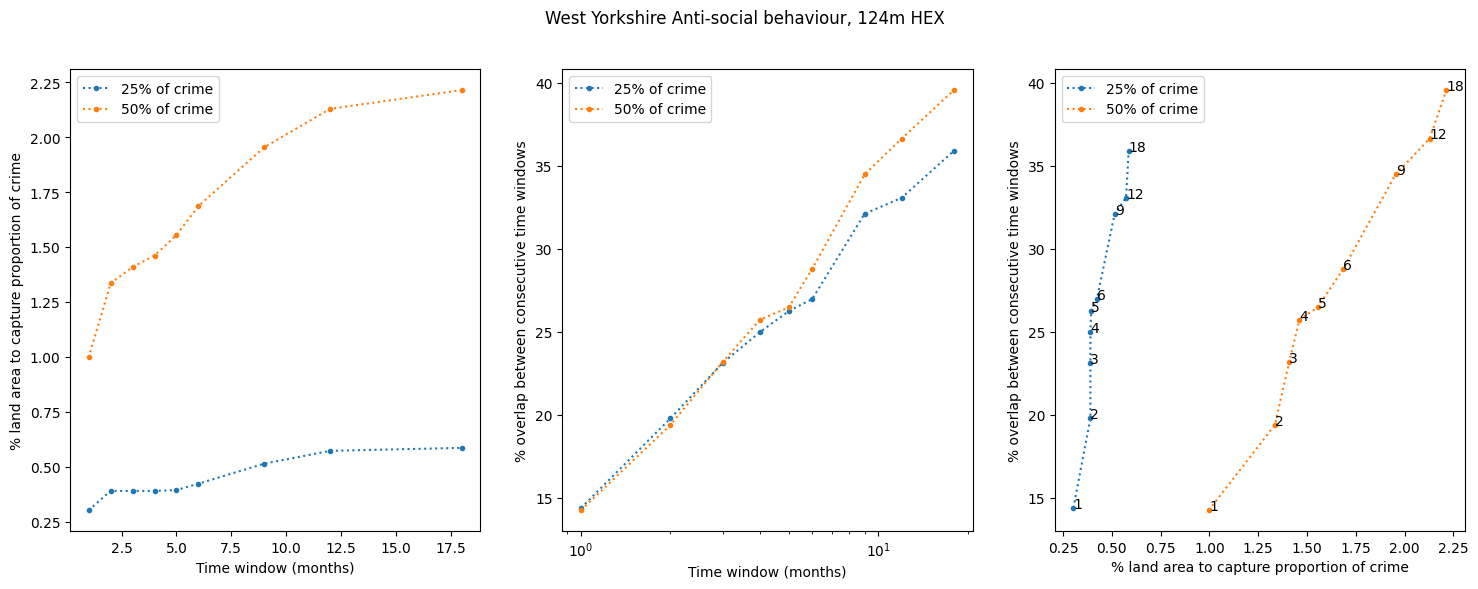

In [173]:
def plot(
    land_area: pd.DataFrame, overlap: pd.DataFrame, crime_type: str, feature_size: float, feature_type: SpatialUnit
) -> None:
    both = land_area.join(overlap, lsuffix="_land_area").reset_index(names="months")

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"West Yorkshire {crime_type}, {feature_size:.0f}m {feature_type}")

    land_area.plot(
        marker=".",
        ls=":",
        ylabel="% land area to capture proportion of crime",
        xlabel="Time window (months)",
        ax=axs[0],
    )

    overlap.plot(
        logx=True,
        marker=".",
        ls=":",
        ylabel="% overlap between consecutive time windows",
        xlabel="Time window (months)",
        ax=axs[1],
    )
    axs[2].plot(both["25% of crime_land_area"], both["25% of crime"], label="25% of crime", ls=":", marker=".")
    axs[2].plot(both["50% of crime_land_area"], both["50% of crime"], label="50% of crime", ls=":", marker=".")
    axs[2].set_xlabel("% land area to capture proportion of crime")
    axs[2].set_ylabel("% overlap between consecutive time windows")
    axs[2].legend()

    for x, y, text in zip(both["25% of crime_land_area"], both["25% of crime"], both.months):
        axs[2].text(x, y, text)
    for x, y, text in zip(both["50% of crime_land_area"], both["50% of crime"], both.months):
        axs[2].text(x, y, text)


plot(land_area, overlap, crime_data["Crime type"].iloc[0], feature_size[feature_type], feature_type)

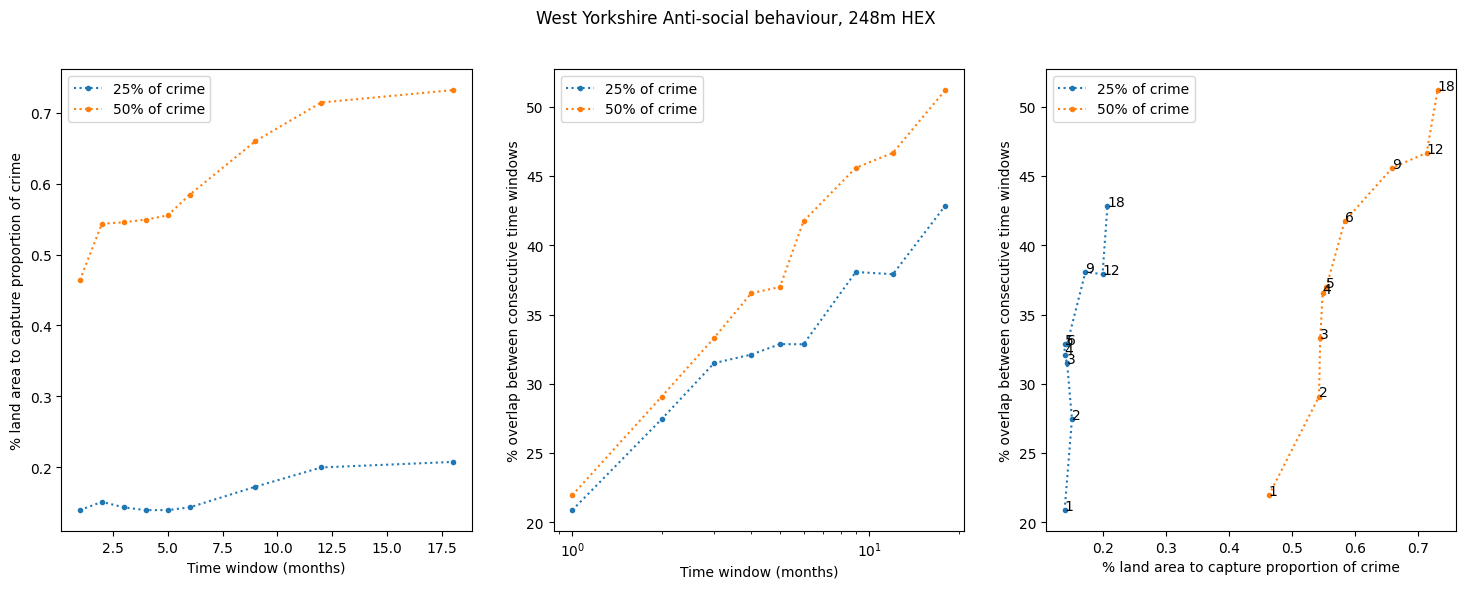

In [174]:
crime_data_400, _ = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type] * 2)
land_area_400, overlap_400 = calc_land_area(crime_data_400, windows), calc_overlap(crime_data_400, windows)
plot(land_area_400, overlap_400, crime_data["Crime type"].iloc[0], feature_size[feature_type] * 2, feature_type)

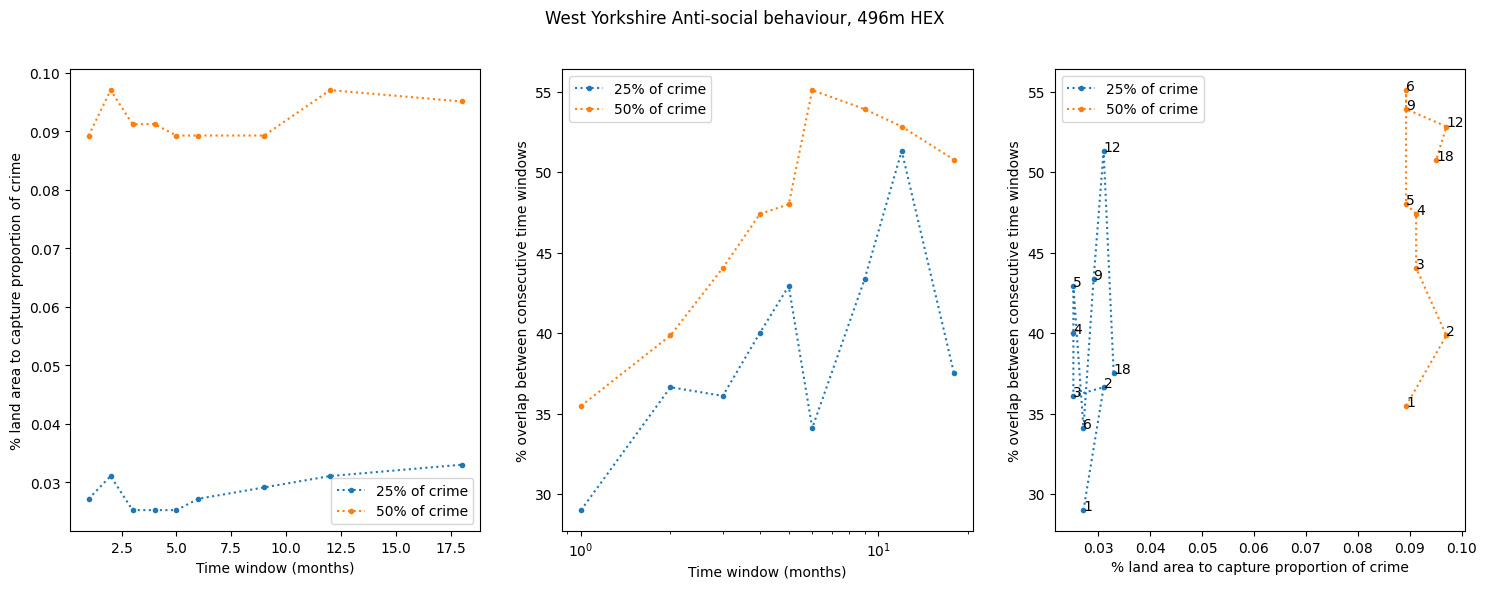

In [175]:
crime_data_800, _ = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type] * 4)
land_area_800, overlap_800 = calc_land_area(crime_data_800, windows), calc_overlap(crime_data_800, windows)
plot(land_area_800, overlap_800, crime_data["Crime type"].iloc[0], feature_size[feature_type] * 4, feature_type)

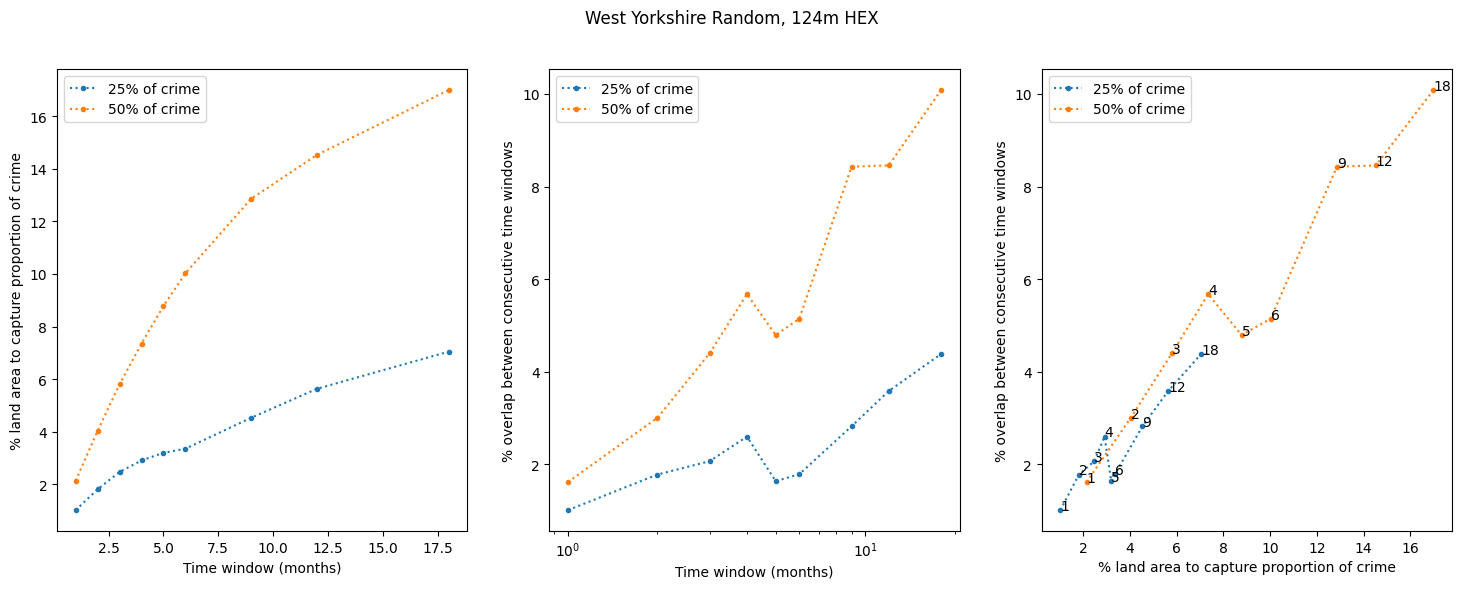

In [176]:
ref_crime_data = random_crime_data(len(raw_crime_data), boundary, list(raw_crime_data.Month.unique()))
ref_crime_data, _ = map_to_spatial_unit(ref_crime_data, boundary, feature_type, size=feature_size[feature_type])
land_area_ref, overlap_ref = calc_land_area(ref_crime_data, windows), calc_overlap(ref_crime_data, windows)
plot(land_area_ref, overlap_ref, ref_crime_data["Crime type"].iloc[0], feature_size[feature_type], feature_type)

In [108]:
crime_data
ref_crime_data

,Month,Crime type,geometry
0,2022-06,Random,POINT (388763.114 424530.577)
1,2024-08,Random,POINT (388819.496 425279.494)
2,2025-03,Random,POINT (388847.602 424759.939)
3,2022-11,Random,POINT (388850.15 425393.024)
4,2022-09,Random,POINT (388868.828 425431.037)
...,...,...,...
81800,2022-07,Random,POINT (452774.369 422646.066)
81801,2024-01,Random,POINT (452781.253 422463.555)
81802,2023-11,Random,POINT (452823.431 422631.796)
81803,2025-02,Random,POINT (452920.019 422356.218)
